In [1123]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os
from scipy.stats import linregress
# import chain

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import chain

from os.path import isfile, join

saveFigures = False
plt.rcParams['figure.figsize'] = (14, 6)
# plt.rcParams['figure.figsize'] = (10, 6)
# plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.dpi'] = 300

asdf

In [1124]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def is_increasing(L):
    return L[0] < L[len(L) - 1] and len(L) > 1
def is_decreasing(L):
    return L[0] > L[len(L) - 1] and len(L) > 1
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of [voltages] and [currents] as arguments
def sort_into_side(voltage, current):
    if is_increasing(voltage) and is_increasing(current):
        return "posThresh"
    elif is_decreasing(voltage) and is_decreasing(current):
        return "posHold"
    elif is_decreasing(voltage) and is_increasing(current):
        return "negThresh"
    elif is_increasing(voltage) and is_decreasing(current):
        return "negHold"
    else: 
        print("???")
        # print("error determining type of data. V: ", voltage, " I: ", current)

def get_rand_id():
    return np.random.randint(1000000000)

def find_index_of_closest_number_in_list(float_list, number):
    closest_index = 0  # Initialize with the index of the first value in the list
    closest_difference = abs(float_list[0] - number)  # Initialize with the absolute difference

    for i in range(1, len(float_list)):
        difference = abs(float_list[i] - number)
        if difference < closest_difference:
            closest_index = i
            closest_difference = difference

    return closest_index

def is_within_percentage_threshold(number, reference, percentage):
    # Calculate the allowable range based on the reference and percentage
    allowable_range = reference * (percentage / 100)
    # Check if the number is within the allowable range
    return abs(number - reference) <= allowable_range



asdf

In [1125]:
# # Create a figure and the primary y-axis
# fig, ax1 = plt.subplots()

# # Create the line plot on the primary y-axis
# ax1.plot(x, y, label="Line Example", color="b")

# # Set labels and title for the primary y-axis
# ax1.set_xlabel("X-axis Label")
# ax1.set_ylabel("Y-axis Label (Bottom)", color="b")

# # Duplicate the x-axis to the top
# ax2 = ax1.twiny()

class Graph: 
    def __init__(self, title, xlabel, ylabel, hlines, type_of_graph, data_to_graph, points, legends):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.hlines = hlines
        self.type = type_of_graph
        self.data_to_graph = data_to_graph
        self.points = points
        self.legends = legends

        # print("legends: ", legends)
        self.color_pool = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', ]
        # self.color_pool = ['blue', 'orange', 'black', 'magenta', 'yellow', 'cyan', 'pink', 'magenta', 'yellow', 'black', 'brown']
        # self.color_pool = ['blue', 'cyan', 'orange', 'blue', 'cyan', 'orange', 'blue', 'red', 'cyan', 'orange', 'blue', 'red', 'cyan', 'orange', 'blue', 'red', 'cyan', 'orange']
        self.show()
        # self.fit_to_line()

    def show(self):
        
        fig, ax = plt.subplots()
        if self.type == "multiPlot":
            ax2 = ax.twinx()
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        # plt.xlim(2, 30)
        # plt.ylim(2, 23)
        ax.grid()

  




        if self.type == "box":
            # print(self.data_to_graph)
            ax.boxplot(self.data_to_graph, labels=self.points)
        else:
            for i in range(len(self.data_to_graph) - 0):
                x = self.data_to_graph[i][0]
                y = self.data_to_graph[i][1]
                color = self.color_pool[i]
                if self.type == "semilogy":
                    if len(self.legends) > 0:
                        # print("self.legends[i]: ", self.legends)
                        # print("data_to_graph: ", self.data_to_graph)
                        # print("x: ", x)
                        # print("y: ", y)

                        ax.semilogy(x, y, color='black', label=self.legends)
                    else:
                        ax.semilogy(x, y, color='black')
                elif self.type == "multiPlot" and len(x) > 1:
                    ax.plot(x, y, color='blue', label=self.legends) 
                    

                    y2 = self.data_to_graph[i][4]

                    # print("0: ", y2[0])
                    # print("1: ", y2[1])
                    # print("2: ", y2[2])
                    # print("3: ", y2[3])
                    # print("4: ", y2[4])


                    # color = 'tab:red'
                    ax2.set_ylabel('Power', color="tab:red")
                    ax2.plot(x, y2, color="red")
                    ax2.tick_params(axis='y', labelcolor="red")



                elif self.type == "plot" and len(x) > 1: 

                    # ax.plot(x, y, color=color)

                    # array_size = (int)(len(x) * 0.1)

                    # if array_size < 10:
                        # array_size = 10
                    
                    # my_array_size = 10

                    # x_fits_beginning = np.array(x[:my_array_size])
                    # y_fits_beginning = np.array(y[:my_array_size])
                    # x_fits_end = np.array(x[-my_array_size:])
                    # y_fits_end = np.array(y[-my_array_size:])

                    # energy_level = ""
                    # slope, intercept, r_value, p_value, std_err = linregress(x_fits_end, y_fits_end)
                    # Ea = 1000 * slope * (0.000086)
                    # energy_level = "E_a: " + str(round(Ea, 3)) + " - "
                    # my_legend = self.legends[i] + energy_level
                    # line_of_best_fit_end = (slope * x_fits_end) + intercept

                    # energy_level = ""
                    # slope, intercept, r_value, p_value, std_err = linregress(x_fits_beginning, y_fits_beginning)
                    # Ea = 1000 * slope * (0.000086)
                    # energy_level = str(round(Ea, 3)) + " eV"
                    # # my_legend = ""
                    # my_legend = my_legend + energy_level
                    # line_of_best_fit = (slope * x_fits_beginning) + intercept



                    
                    

                    try: 
                        ax.plot(x, y, color=color, label=self.legends[i])   
                        ax.legend(loc='upper left')
                    except Exception as e:
                        # Code to handle other exceptions
                        ax.plot(x, y, color=color)   


                    # ax.plot(x_fits_beginning, line_of_best_fit, color='red', linewidth=2)
                    # ax.plot(x_fits_end, line_of_best_fit_end, color='green', linewidth=2)
                    
                        
                        
                    
                elif self.type == "box":
                    ax.boxplot(x, y, color=color)
                    # ax.boxplot(x, y, color=color, label=self.legends[i])
                
                # ax.legend(loc="upper right", title="Legend Title")
            
                    
            for i in range(len(self.hlines)):
                ax.axhline(y = self.hlines[i], color = 'r', linestyle = '-')

            for i in range(len(self.points)):
                color_to_use = "red"
                if self.points[i][2] == "posHold": 
                    color_to_use = "blue"
                if self.points[i][2] == "negThresh": 
                    color_to_use = "green"
                if self.points[i][2] == "negHold": 
                    color_to_use = "orange"

                ax.plot(self.points[i][0], self.points[i][1], marker="o", markersize=10, markeredgecolor=color_to_use, markerfacecolor=color_to_use)
        # print(ax.get_xticks())
        
        # ax2 = ax.secondary_xaxis("top")
        # x_ticks_with_hi = [round((1 / (x_tick + 0.000000001)) * 1000) for x_tick in ax.get_xticks()]
        # for tick_index in range(len(x_ticks_with_hi) - 1):
        #     if (x_ticks_with_hi[tick_index] == 1000000000000):
        #         x_ticks_with_hi[tick_index] = 0
                
        # # print(x_ticks_with_hi)
        # ax2.set_xticklabels(x_ticks_with_hi)
        # ax2.set_xlabel('Temperature [K]')

        

        
        if saveFigures: 
            plt.savefig('figures/Nov15/' + self.title[:25] + '.png', bbox_inches='tight')
        plt.figure(get_rand_id())
        plt.show()

    # def fit_to_line(self):
    #     print("fdsa")

asdf

In [1126]:
def read_file_data(data):
    # REMOVE BAD DATA: read all the data and remove the rows when we are very close to the max current
    rows_to_exclude = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=1)
    data_from_file = rows_to_exclude.values
    rows_to_exclude.head()
    I_to_skip = data_from_file[:,1]
    # the cut off value for the max current is 0.9999999 * the highest current recorded in the file
    max_current = np.max(I_to_skip) * 0.9999999
    # print("max current: ", max_current)
    over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]
    # print("over_max_current_indexes: ", over_max_current_indexes)
    # read the file again without the rows that have a current above the threshold
    df5 = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)
    # df5.head()
    return df5.values

def createDataDictionary(data, start, stop):
    dI = np.gradient(data.I[start:stop])
    ddI = np.gradient(np.gradient(data.I[start:stop]))
    run_temp = np.average(data.temps[start:stop])
    run_temp_std = np.std(data.temps[start:stop])
    return {
        'time': data.time[start:stop],
        'I': data.I[start:stop],
        'R': data.R[start:stop],
        'dI': dI,
        'ddI': ddI,
        'V': data.V[start:stop],
        'P': data.I.copy()[start:stop] * data.V.copy()[start:stop],
        'temps': data.temps[start:stop],
        'temp': run_temp,
        'temp_std': run_temp_std,
        'type_of_data': sort_into_side(data.V[start:stop], data.I[start:stop]),
        'max_ddI': np.argmax(ddI),
    }


def count_IV_curves(data):
    pos_thresh_IV_curve_count = 0
    pos_hold_IV_curve_count = 0
    neg_thresh_IV_curve_count = 0
    neg_hold_IV_curve_count = 0
    for IV_curve in data.IV_curves:
        if IV_curve['type_of_data'] == "posThresh":
            pos_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negThresh":
            neg_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "posHold":
            pos_hold_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negHold":
            neg_hold_IV_curve_count += 1
    return [pos_thresh_IV_curve_count, pos_hold_IV_curve_count, neg_thresh_IV_curve_count, neg_hold_IV_curve_count]

In [1127]:
# this will take a file name
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.pos_hold_voltages = []
        self.neg_hold_voltages = []

        self.pos_thresh_voltages = []
        self.neg_thresh_voltages = []
        self.filePath = file_path
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        try:
            self.break_all_data_into_IV_curves()
            self.get_temp_range()
        except Exception as e:
            # Code to handle other exceptions
            print(f"An error occurred: {e} ", self.file_name)
        # self.count_IV_curve_types()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("summerData/")[1]
        # print(self.file_name)

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):

        data = read_file_data(self)
        
        
        # print("number of data points: ", self.number_of_data_points)

        indices_greater_than_01 = [index for index, value in enumerate(data[:,1]) if value >= 0.01]
        
        interval = 1
        time = np.arange(0, len(data[:,0])) * interval

        current = data[:,1]
        voltage = data[:,2]
        temps = data[:,3]

        # print("temps before: ", temps)
        # print("temps len: ", len(temps))

        # print("current type: ", type(current))

        self.time = np.array([time[i] for i in range(len(time)) if i not in indices_greater_than_01])
        self.I = np.array([current[i] for i in range(len(current)) if i not in indices_greater_than_01])
        self.V = np.array([voltage[i] for i in range(len(voltage)) if i not in indices_greater_than_01])
        self.temps = np.array([temps[i] for i in range(len(temps)) if i not in indices_greater_than_01])

        self.number_of_data_points = len(data[:,0])


        

        # print("indices_greater_than_2: ", indices_greater_than_01)

        self.R = self.V / self.I
        # self.R = np.abs(self.R)

    def graph_all_data(self):
        fig, ax = plt.subplots()
        plt.title("All Data")
        plt.xlabel("Voltage (V)")
        plt.ylabel("Current (A)")
        ax.grid()
        ax.semilogy(self.V, self.I, color='black')
        # the_graph = Graph(
        #     self.file_name[19:-4] +  " All Data",         # title
        #     "Voltage (V)",      # xlabel
        #     "Current (A)",      # ylabel
        #     [], # hlines
        #     "semilogy",         # type of graph
        #     [[self.V, self.I]],   # data to graph
        #     [],                 # points
        #     [],                 # legends
        # )

    def break_all_data_into_IV_curves(self):
        # get the index of every "0" value in the voltage array
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        # print(self.all_zero_indexes)

        # removing the frist and last 4 reduces the number of crashes
        self.all_zero_indexes = self.all_zero_indexes[4:]
        self.all_zero_indexes = self.all_zero_indexes[:-4]

        self.IV_curves = []
        self.all_data_in_runs = []

        # gets the following data out of the file: 'I' 'R' 'dI' 'ddI' 'V' 'temps' 'temp' 'temp_std' 'type_of_data' 'max_ddI' and stores it ina dictionary
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i]
            stop = (int)(start + ((self.all_zero_indexes[i+1] - start) / 2))
            self.IV_curves.append(createDataDictionary(self, start, stop))

            start = (int)(self.all_zero_indexes[i] + ((self.all_zero_indexes[i+1] - start) / 2))
            stop = self.all_zero_indexes[i+1]
            self.IV_curves.append(createDataDictionary(self, start, stop))

        self.number_of_IV_curves = (len(self.IV_curves) - 1) * 1
        # print("number of IV curves: ", self.number_of_IV_curves)

    def get_temp_range(self):

        all_temps = []
        for i in range(0, self.number_of_IV_curves):
            temp = self.IV_curves[i]['temp']
            all_temps.append(temp)
        
        self.all_temps = all_temps
        
        # min_temp = max(all_temps) - 2
        # max_temp = min(all_temps) + 2

        min_temp = all_temps[5] 
        max_temp = all_temps[len(all_temps) - 5 ] 

        # print("temps: ", max_temp, min_temp)
        
        self.temp_range = [min_temp, max_temp]

    def count_IV_curve_types(self):
        iv_curve_types = count_IV_curves(self)

        print("pos_thresh_IV_curve_count: ", iv_curve_types[0])
        print("pos_hold_IV_curve_count: ", iv_curve_types[1])
        print("neg_thresh_IV_curve_count: ", iv_curve_types[2])
        print("neg_hold_IV_curve_count: ", iv_curve_types[3])

    def get_IV_curve_data(self, index):
        data_to_graph = []
        points_to_graph = []

        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph], type_of_data])

        title_time = str(round(self.IV_curves[index]['time'][0])) + " s"
        title_temp = str(round(self.IV_curves[index]['temp'])) + "K "
        title =  self.file_name.split("23_")[1][:-4] + " " + str(index) + "_" + str((self.number_of_IV_curves))

        print("self.number_of_IV_curves: ", self.number_of_IV_curves)

        return [
            title,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
            [],                 #legends
        ]
    
    def get_IV_curve_data_by_temp(self, temp):
        data_to_graph = []
        points_to_graph = []

        index = find_index_of_closest_number_in_list(self.all_temps[0:-5], temp)

        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph], type_of_data])

        title_time = str(round(self.IV_curves[index]['time'][0])) + " s"
        title_temp = str(round(self.IV_curves[index]['temp'])) + "K "
        title = "IVcurve_" + str(index) + title_time + title_temp

        return [
            title_temp,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
            [],                 #legends
        ]


    def graph_IV_curve(self, index):
        ic_curve_data = self.get_IV_curve_data(index)
        the_graph = Graph(
            ic_curve_data[0],   # title
            ic_curve_data[1],   # xlabel
            ic_curve_data[2],   # ylabel
            ic_curve_data[3],   # hlines
            ic_curve_data[4],   # type of graph
            ic_curve_data[5],   # data to graph
            ic_curve_data[6],   # points
            ic_curve_data[7],   #legends
        )


    def graph_IV_curves(self, number_of_graphs):
        for x in range(0, number_of_graphs):
            i = (int)(((self.number_of_IV_curves) / number_of_graphs) * x)
            self.graph_IV_curve(i)

    def overlay_IV_curves(self, number_of_graphs):
        print(self.file_name)
        min_temp = self.temp_range[0]
        max_temp = self.temp_range[1]
        temp_step = (max_temp - min_temp) / (number_of_graphs)

        print("min temp:", min_temp)
        print("max temp:", max_temp)
        print("step temp:", temp_step)

        iv_curves = []
        temp_to_graph = min_temp
        for x in range(0, number_of_graphs):
            iv_curves.append(self.get_IV_curve_data_by_temp(temp_to_graph))
            temp_to_graph  = temp_to_graph + temp_step

        title = "Sam " + self.file_name.split("_Sam")[1][:-4] + iv_curves[0][0] + iv_curves[1][0] + iv_curves[2][0] + iv_curves[3][0] + iv_curves[4][0]
        xlabel = iv_curves[0][1]
        ylabel = iv_curves[0][2]
        hlines = iv_curves[0][3]
        type_of_graph = iv_curves[0][4]
        data_to_graph = iv_curves[0][5] + iv_curves[1][5] + iv_curves[2][5] + iv_curves[3][5] + iv_curves[4][5]
        points = iv_curves[0][6] + iv_curves[1][6] + iv_curves[2][6] + iv_curves[3][6] + iv_curves[4][6]
        legends = [iv_curves[0][0], iv_curves[1][0], iv_curves[2][0], iv_curves[3][0], iv_curves[4][0]]

        print("type_of_graph: ", type_of_graph)



#         type_of_graph:  semilogy
# self.legends[i]:  293K 
# data_to_graph:  [[array([0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4,
#        0.44, 0.48, 0.52, 0.56, 0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.84,
#        0.88, 0.92, 0.96, 1.0, 1.04, 1.08, 1.12, 1.16, 1.2, 1.24, 1.28,
#        1.32, 1.36, 1.4, 1.44, 1.48, 1.52, 1.56, 1.6, 1.64, 1.68, 1.72,
#        1.76, 1.8, 1.84, 1.88, 1.92, 1.96], dtype=object), array([2.193416e-09, 3.157056e-05, 6.431015e-05, 9.921956e-05,
#        0.0001371212, 0.0001789673, 0.0002255824, 0.0002778806,
#        0.0003369182, 0.0004037039, 0.000479396, 0.0005651839, 0.00066164,
#        0.0007695711, 0.0008879844, 0.001000009, 0.00100001, 0.00100001,
#        0.001000008, 0.001000009, 0.001000009, 0.001000011, 0.001000007,
#        0.001000008, 0.00100001, 0.001000009, 0.001000009, 0.001000009,
#        0.001000007, 0.001000007, 0.001000008, 0.001000009, 0.001000007,
#        0.001000007, 0.00100001, 0.001000006, 0.001000006, 0.001000008,
#        0.001000007, 0.001000008, 0.001000007, 0.001000006, 0.001000004,
#        0.001000006, 0.001000006, 0.001000006, 0.001000008, 0.001000007,
#        0.001000006, 0.001000006], dtype=object)], [array([2.0, 1.96, 1.92, 1.88, 1.84, 1.8, 1.76, 1.72, 1.68, 1.64, 1.6,
#        1.56, 1.52, 1.48, 1.44, 1.4, 1.36, 1.32, 1.28, 1.24, 1.2, 1.16,
#        1.12, 1.08, 1.04, 1.0, 0.96, 0.92, 0.88, 0.84, 0.8, 0.76, 0.72,
#        0.68, 0.64, 0.6, 0.56, 0.52, 0.48, 0.44, 0.4, 0.36, 0.32, 0.28,
#        0.24, 0.2, 0.16, 0.12, 0.08, 0.04], dtype=object), array([0.001000006, 0.001000005, 0.001000007, 0.001000006, 0.001000006,
#        0.001000007, 0.001000006, 0.001000005, 0.001000008, 0.001000005,
#        0.001000005, 0.001000008, 0.001000005, 0.001000006, 0.001000007,
#        0.001000006, 0.001000006, 0.001000006, 0.001000006, 0.001000007,
#        0.001000007, 0.001000005, 0.001000006, 0.001000007, 0.001000008,
#        0.001000007, 0.001000007, 0.001000007, 0.001000008, 0.001000009,
#        0.001000008, 0.001000008, 0.001000008, 0.001000011, 0.0009864585,
#        0.0008768299, 0.0007739561, 0.0006784138, 0.0005903582,
#        0.0005101326, 0.0004375062, 0.0003719891, 0.0003131723,
#        0.0002603198, 0.000212688, 0.000169684, 0.0001306402, 9.48739e-05,
#        6.165922e-05, 3.03217e-05], dtype=object)], 

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )
        



        # print(iv_curves[0])
        # print(iv_curves[1])




    def graph_IV_curves_at_temp(self, start, stop):
        for i in range(0, len(self.IV_curves) - 1, 4):
            temp = self.IV_curves[i]['temp']
            if temp > start and temp < stop: 
                self.graph_IV_curve(i)






    def graph_r_vs_log_i(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        tempXAxis = []
        tempYAxis = []
        tempTemps = []

        for IV_curve in self.IV_curves:
            current = IV_curve['I']
            resistance = IV_curve['R']
            temp = IV_curve['temps']
            tempXAxis.append(current)
            tempYAxis.append(resistance)
            tempTemps.append(temp)

        first_ten_temps = []    
        second_ten_temps = []    

        for i in range(0, 50):
            if i % 5 == 0:
                for index in range(len(tempXAxis[i])):
                    xAxis.append(np.log10(tempXAxis[i][index]))
                    yAxis.append((np.abs(tempYAxis[i][index])))
                    first_ten_temps.append(tempTemps[i][index])
        
        for i in range(50, 100):
            if i % 5 == 0:
                for index in range(len(tempXAxis[i])):
                    xAxis2.append(np.log10(tempXAxis[i][index]))
                    yAxis2.append((np.abs(tempYAxis[i][index])))
                    second_ten_temps.append(tempTemps[i][index])


        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2]]
        legends = ["first 10 temps ≈" + str(round(np.average(first_ten_temps))) + " K", "second 10 temps ≈" + str(round(np.average(second_ten_temps))) + " K"]

        the_graph = Graph(
            self.file_name[19:-4] +  " log10_I vs R",   # title
            "Log10(I) (A)",                             # xlabel
            "Resistance (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )







    def graph_log_r_vs_voltage(self):
        xAxis = []
        yAxis = []

        tempXAxis = []
        tempYAxis = []

        for IV_curve in self.IV_curves:
            resistance = IV_curve['R']
            voltage = IV_curve['V']
            tempXAxis.append(voltage)
            tempYAxis.append(resistance)

        for i in range(len(tempXAxis) - 1):
            if i % 5 == 0:
                for index in range(len(tempXAxis[i])):
                    xAxis.append(tempXAxis[i][index])
                    yAxis.append(np.log10(np.abs(tempYAxis[i][index])))


        data_to_graph = [[xAxis, yAxis]]

        # print("data_to_graph: ", data_to_graph)
        legends = []

        # print(xAxis)

        the_graph = Graph(
            self.file_name[19:-4] +  " v vs ln_R",   # title
            "Voltage (V)",                             # xlabel
            "Ln(R) (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )




    

    def graph_R_vs_T_constant_P(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        xAxis5 = []
        yAxis5 = []


        for IV_curve in self.IV_curves:
            power = IV_curve['P']
            resistance = IV_curve['R']
            temps = IV_curve['temps']

            powerIndex = find_index_of_closest_number_in_list(power, 0.0001)
            if is_within_percentage_threshold(power[powerIndex], 0.0001, 2.5):
                xAxis.append(1000 / temps[powerIndex])
                yAxis.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.00001)
            if is_within_percentage_threshold(power[powerIndex], 0.00001, 2.5):
                xAxis2.append(1000 / temps[powerIndex])
                yAxis2.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.000005)
            if is_within_percentage_threshold(power[powerIndex], 0.000005, 2.5):
                xAxis3.append(1000 / temps[powerIndex])
                yAxis3.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.0000025)
            if is_within_percentage_threshold(power[powerIndex], 0.0000025, 2.5):
                xAxis4.append(1000 / temps[powerIndex])
                yAxis4.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.000001)
            if is_within_percentage_threshold(power[powerIndex], 0.000001, 2.5):
                xAxis5.append(1000 / temps[powerIndex])
                yAxis5.append(np.log(resistance[powerIndex]))


        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4], [xAxis5, yAxis5]]
        legends = ["0.0001 W", "0.00001 W", "0.000005 W", "0.0000025 W", "0.000001 W"]
        the_graph = Graph(
            self.file_name[19:-4] +  " ln(R) vs 1000/T constant P",   # title
            "1000 / Temperature",                             # xlabel
            "ln(R) (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )









    def graph_voltage_vs_temp_type(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(temp)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(temp)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(temp)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(temp)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]
        legends = ["posThresh - " + str(len(xAxis)), "negThresh - " + str(len(xAxis2)), "posHold - " + str(len(xAxis3)), "negHold - " + str(len(xAxis4))]

        # print(xAxis)

        the_graph = Graph(
            self.file_name[19:-4] +  " Special V vs T",   # title
            "Temperature (K)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )


    def graph_voltage_vs_resistance(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(resistance)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(resistance)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(resistance)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(resistance)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]

        # print(xAxis)

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Resistance",   # title
            "Resistance (Ω)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )


    def graph_voltage_vs_temp(self):
        xAxis_posThresh = []
        yAxis_posThresh = []

        xAxis_negThresh = []
        yAxis_negThresh = []

        xAxis_posHold = []
        yAxis_posHold = []

        xAxis_negHold = []
        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            temp = IV_curve['temp']
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                xAxis_posThresh.append(temp)
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                xAxis_negThresh.append(temp)
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                xAxis_posHold.append(temp)
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                xAxis_negHold.append(temp)
                yAxis_negHold.append(current)

        data_to_graph = [
            [xAxis_posThresh, yAxis_posThresh],
            [xAxis_negThresh, yAxis_negThresh],
            [xAxis_posHold, yAxis_posHold],
            [xAxis_negHold, yAxis_negHold],
            ]

        the_graph = Graph(
            self.file_name[13:-4] +  " Special Voltage vs Temp",   # title
            "Temp (K)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )

    def return_voltage_vs_temp(self):
        yAxis_posThresh = []

        yAxis_negThresh = []

        yAxis_posHold = []

        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                yAxis_negHold.append(current)

        data_to_graph = [
            yAxis_posThresh,
            yAxis_negThresh,
            yAxis_posHold,
            yAxis_negHold
            ]

        return data_to_graph

    def graph_resistance_vs_temp(self):

        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001    # 1e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = [[], [], [], []]
        y1Axis = [[], [], [], []]

        x2Axis = [[], [], [], []]
        y2Axis = [[], [], [], []]

        x3Axis = [[], [], [], []]
        y3Axis = [[], [], [], []]

        for current_to_plot in currents_to_plot:
            for IV_curve in self.IV_curves:
                temp = IV_curve['temp']
                
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                resistance = IV_curve['R'][number]

                # for i in range(len(currents_to_plot) - 1):

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis[0].append(temp)
                        y1Axis[0].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negThresh":
                        x1Axis[1].append(temp)
                        y1Axis[1].append(abs(resistance))
                    if IV_curve['type_of_data'] == "posHold":
                        x1Axis[2].append(temp)
                        y1Axis[2].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negHold":
                        x1Axis[3].append(temp)
                        y1Axis[3].append(abs(resistance))

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis[0].append(temp)
                        y2Axis[0].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negThresh":
                        x2Axis[1].append(temp)
                        y2Axis[1].append(abs(resistance))
                    if IV_curve['type_of_data'] == "posHold":
                        x2Axis[2].append(temp)
                        y2Axis[2].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negHold":
                        x2Axis[3].append(temp)
                        y2Axis[3].append(abs(resistance))

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis[0].append(temp)
                        y3Axis[0].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negThresh":
                        x3Axis[1].append(temp)
                        y3Axis[1].append(abs(resistance))
                    if IV_curve['type_of_data'] == "posHold":
                        x3Axis[2].append(temp)
                        y3Axis[2].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negHold":
                        x3Axis[3].append(temp)
                        y3Axis[3].append(abs(resistance))                

        data_to_graph = [
                        [x1Axis[0], y1Axis[0]], # 0 posThresh 
                        [x1Axis[1], y1Axis[1]], # 0 negThresh

                        [x1Axis[2], y1Axis[2]], # 0 posHold
                        [x1Axis[3], y1Axis[3]], # 0 negHold  

                        [x2Axis[0], y2Axis[0]], # 1 posThresh
                        [x2Axis[1], y2Axis[1]], # 1 negThresh

                        [x2Axis[2], y2Axis[2]], # 1 posHold
                        [x2Axis[3], y2Axis[3]], # 1 negHold

                        [x3Axis[0], y3Axis[0]], # 2 posThresh
                        [x3Axis[1], y3Axis[1]], # 2 negThresh

                        [x3Axis[2], y3Axis[2]], # 2 posHold
                        [x3Axis[3], y3Axis[3]]  # 2 negHold
        ]

        legends = [
            str(currents_to_plot[0]) + " A posThresh",
            str(currents_to_plot[0]) + " A negThresh",
            str(currents_to_plot[0]) + " A posHold",
            str(currents_to_plot[0]) + " A negHold",

            str(currents_to_plot[1]) + " A posThresh",
            str(currents_to_plot[1]) + " A negThresh",
            str(currents_to_plot[1]) + " A posHold",
            str(currents_to_plot[1]) + " A negHold",

            str(currents_to_plot[2]) + " A posThresh",
            str(currents_to_plot[2]) + " A negThresh",
            str(currents_to_plot[2]) + " A posHold",
            str(currents_to_plot[2]) + " A negHold"
                       
            ]
        # print("data_to_graph: ", data_to_graph)

        the_graph = Graph(
            self.file_name[13:-4] +  " R vs T",   # title
            "Temp (K)",                             # xlabel
            "Resistance (Ω)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )


    def graph_log_r_vs_1_over_temp(self):
        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001,    # 1e-4
            # 0.000005, # 5e-6
            # # 0.000001, # 5e-6
            # 0.00005, # 5e-5
            # # 0.00001, # 5e-5
            # 0.0005,  #  5e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = [[], [], [], []]
        y1Axis = [[], [], [], []]

        x2Axis = [[], [], [], []]
        y2Axis = [[], [], [], []]

        x3Axis = [[], [], [], []]
        y3Axis = [[], [], [], []]

        x4Axis = [[], [], [], []]
        y4Axis = [[], [], [], []]

        x5Axis = [[], [], [], []]
        y5Axis = [[], [], [], []]

        for IV_curve in self.IV_curves: 
            for current_to_plot in currents_to_plot:
                temp = 1000 / IV_curve['temp']
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                voltage = IV_curve['V'][number]
                resistance = np.log(abs(IV_curve['R'][number]))

                # for i in range(len(currents_to_plot) - 1):

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis[0].append(temp)
                        y1Axis[0].append(resistance)
                    # if IV_curve['type_of_data'] == "negThresh":
                    #     x1Axis[1].append(temp)
                    #     y1Axis[1].append(resistance)
                    # if IV_curve['type_of_data'] == "posHold":
                    #     x1Axis[2].append(temp)
                    #     y1Axis[2].append(resistance)
                    # if IV_curve['type_of_data'] == "negHold":
                    #     x1Axis[3].append(temp)
                    #     y1Axis[3].append(resistance)

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis[0].append(temp)
                        y2Axis[0].append(resistance)
                    # if IV_curve['type_of_data'] == "negThresh":
                    #     x2Axis[1].append(temp)
                    #     y2Axis[1].append(resistance)
                    # if IV_curve['type_of_data'] == "posHold":
                    #     x2Axis[2].append(temp)
                    #     y2Axis[2].append(resistance)
                    # if IV_curve['type_of_data'] == "negHold":
                    #     x2Axis[3].append(temp)
                    #     y2Axis[3].append(resistance)

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis[0].append(temp)
                        y3Axis[0].append(resistance)

                # if current_to_plot == currents_to_plot[3] and is_within_percentage_threshold(current, currents_to_plot[3], threshhold_percentage):
                #     if IV_curve['type_of_data'] == "posThresh":
                #         x4Axis[0].append(temp)
                #         y4Axis[0].append(resistance)

                # if current_to_plot == currents_to_plot[4] and is_within_percentage_threshold(current, currents_to_plot[4], threshhold_percentage):
                #     if IV_curve['type_of_data'] == "posThresh":
                #         x5Axis[0].append(temp)
                #         y5Axis[0].append(resistance)


                    # if IV_curve['type_of_data'] == "negThresh":
                    #     x3Axis[1].append(temp)
                    #     y3Axis[1].append(resistance)
                    # if IV_curve['type_of_data'] == "posHold":
                    #     x3Axis[2].append(temp)
                    #     y3Axis[2].append(resistance)
                    # if IV_curve['type_of_data'] == "negHold":
                    #     x3Axis[3].append(temp)
                    #     y3Axis[3].append(resistance)                

        data_to_graph = [
                        [x1Axis[0], y1Axis[0]], # 0 posThresh 
                        # [x1Axis[1], y1Axis[1]], # 0 negThresh

                        # [x1Axis[2], y1Axis[2]], # 0 posHold
                        # [x1Axis[3], y1Axis[3]], # 0 negHold  

                        [x2Axis[0], y2Axis[0]], # 1 posThresh
                        # [x2Axis[1], y2Axis[1]], # 1 negThresh

                        # [x2Axis[2], y2Axis[2]], # 1 posHold
                        # [x2Axis[3], y2Axis[3]], # 1 negHold

                        [x3Axis[0], y3Axis[0]], # 2 posThresh
                        # [x4Axis[0], y4Axis[0]], # 3 posThresh
                        # [x5Axis[0], y5Axis[0]], # 4 posThresh
                        # [x3Axis[1], y3Axis[1]], # 2 negThresh

                        # [x3Axis[2], y3Axis[2]], # 2 posHold
                        # [x3Axis[3], y3Axis[3]]  # 2 negHold
        ]

        legends = [
            str(currents_to_plot[0]) + " A posThresh",
            # str(currents_to_plot[0]) + " A negThresh",
            # str(currents_to_plot[0]) + " A posHold",
            # str(currents_to_plot[0]) + " A negHold",

            str(currents_to_plot[1]) + " A posThresh",
            # str(currents_to_plot[1]) + " A negThresh",
            # str(currents_to_plot[1]) + " A posHold",
            # str(currents_to_plot[1]) + " A negHold",

            str(currents_to_plot[2]) + " A posThresh",
            # str(currents_to_plot[3]) + " A posThresh",
            # str(currents_to_plot[4]) + " A posThresh",
            # str(currents_to_plot[2]) + " A negThresh",
            # str(currents_to_plot[2]) + " A posHold",
            # str(currents_to_plot[2]) + " A negHold"
                       
            ]
        # print("data_to_graph: ", data_to_graph)

            # log_r_vs_1_over_temp
        the_graph = Graph(
            self.file_name[13:-4] +  "lnR vs 1000/T",   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )






    def graph_delta_v_vs_temp(self):
        v_posThresh = []
        v_negThresh = []
        v_posHold = []
        v_negHold = []

        t_posThresh = []
        t_negThresh = []
        t_posHold = []
        t_negHold = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_posThresh.append(temp)
                v_posThresh.append(voltage)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_negThresh.append(temp)
                v_negThresh.append(voltage)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_posHold.append(temp)
                v_posHold.append(voltage)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_negHold.append(temp)
                v_negHold.append(voltage)

        pos_delta_v = np.array(v_posThresh) - np.array(v_posHold)
        neg_delta_v = np.array(v_negThresh) - np.array(v_negHold)

        title = "Delta V vs Temp " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Temp"
        ylabel = "Delta V"
        hlines = []
        type_of_graph = 'plot'
        data_to_graph = [[t_posThresh, pos_delta_v], [t_negThresh, np.abs(neg_delta_v)]]
        points = []
        legends = ['pos delta v', 'neg delta v']

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )








    def graph_power_vs_temp(self):
        p_posThresh = [[],[],[]]
        p_negThresh = [[],[],[]]
        p_posHold = [[],[],[]]
        p_negHold = [[],[],[]]

        t_posThresh = [[],[],[]]
        t_negThresh = [[],[],[]]
        t_posHold = [[],[],[]]
        t_negHold = [[],[],[]]

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_posThresh[0].append(temp)
                p_posThresh[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_posThresh[1].append(temp)
                p_posThresh[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_posThresh[2].append(temp)
                p_posThresh[2].append((power))

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_negThresh[0].append(temp)
                p_negThresh[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_negThresh[1].append(temp)
                p_negThresh[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_negThresh[2].append(temp)
                p_negThresh[2].append((power))

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_posHold[0].append(temp)
                p_posHold[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_posHold[1].append(temp)
                p_posHold[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_posHold[2].append(temp)
                p_posHold[2].append((power))

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_negHold[0].append(temp)
                p_negHold[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_negHold[1].append(temp)
                p_negHold[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_negHold[2].append(temp)
                p_negHold[2].append((power))
        
        data_to_graph = [
            [t_posThresh[0], p_posThresh[0]],[t_posThresh[1], p_posThresh[1]],[t_posThresh[2], p_posThresh[2]],
            [t_negThresh[0], p_negThresh[0]],[t_negThresh[1], p_negThresh[1]],[t_negThresh[2], p_negThresh[2]],
            [t_posHold[0], p_posHold[0]],[t_posHold[1], p_posHold[1]],[t_posHold[2], p_posHold[2]],
            [t_negHold[0], p_negHold[0]],[t_negHold[1], p_negHold[1]],[t_negHold[2], p_negHold[2]]
        ]

        title = "Power vs Temp " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Temp"
        ylabel = "Power"
        hlines = []
        type_of_graph = 'plot'
        # data_to_graph = [[t_posThresh, p_posThresh], [t_negThresh, p_negThresh], [t_posHold, p_posHold], [t_negHold, p_negHold]]
        points = []
        legends = []

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )












    def graph_special_power_vs_temp(self):
        p_posThresh = []
        p_negThresh = []
        p_posHold = []
        p_negHold = []

        t_posThresh = []
        t_negThresh = []
        t_posHold = []
        t_negHold = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_posThresh.append(temp)
                p_posThresh.append(power)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_negThresh.append(temp)
                p_negThresh.append(power)

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "posHold":
        #         temp = IV_curve['temp']
        #         power = IV_curve['P'][IV_curve['max_ddI']]
        #         t_posHold.append(temp)
        #         p_posHold.append(power)

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "negHold":
        #         temp = IV_curve['temp']
        #         power = IV_curve['P'][IV_curve['max_ddI']]
        #         t_negHold.append(temp)
        #         p_negHold.append(power)

        title = "Special Power vs Temp " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Temp"
        ylabel = "Power"
        hlines = []
        type_of_graph = 'plot'
        data_to_graph = [[t_posThresh, p_posThresh], [t_negThresh, np.abs(p_negThresh)]]
        points = []
        legends = ["pos thresh", "neg thresh"]

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )
























    def graph_log_r_vs_1_over_temp_by_voltage(self):
        voltages_to_plot = [
            0.4,
            0.2,  
            0.1   
        ]

        # [[], [], []]
        posThreshData = [[], [], []]
        negThreshData = [[], [], []]

        posHoldData = [[], [], []]
        negHoldData = [[], [], []]

        # print("len: ", len(self.IV_curves))

        for IV_curve in self.IV_curves:
            
            small = self.IV_curves[0]['temp']
            big = self.IV_curves[len(self.IV_curves) - 1]['temp']

            # print("temp: ", IV_curve['temp'], " small: ", small, " big: ", big)


            cutoff = 100

            if small > big: 
                cutoff = (small - big) / 1.5
            if big > small: 
                cutoff = (big - small) / 1.5

            # print(cutoff)

            for index in range(len(IV_curve['V']) - 1):

                voltage = IV_curve['V'][index]
                # resistance = np.log10(abs(IV_curve['R'][index]))
                resistance = np.log(abs(IV_curve['R'][index]))
                temp = 1000 / IV_curve['temp']
                current = IV_curve['I'][index]  

                
                # posThreshData.append()
                
                
                for i in range(len(voltages_to_plot)):
                    # if abs(voltage) == voltages_to_plot[i] and IV_curve['temp'] > cutoff:
                    if abs(voltage) == voltages_to_plot[i]:
                        if IV_curve['type_of_data'] == "posThresh":
                            posThreshData[i].append([temp, resistance])
                        # if IV_curve['type_of_data'] == "negThresh":
                        #     negThreshData[i].append([temp, resistance])
                        # if IV_curve['type_of_data'] == "posHold":
                        #     posHoldData[i].append([temp, resistance])
                        # if IV_curve['type_of_data'] == "negHold":
                        #     negHoldData[i].append([temp, resistance])

                    
        # print("posThreshData: ", posThreshData)
        # print("len(posThreshData): ", len(posThreshData)) 
        # print("len(posThreshData[0]): ", len(posThreshData[0]))

        data_to_graph = []
        legends = []

        for i in range(len(voltages_to_plot)):
            # print(voltages_to_plot[i])
            x = []
            y = []
            for dataPoint in posThreshData[i]:
                x.append(dataPoint[0])
                y.append(dataPoint[1])
            data_to_graph.append([x, y, "posThresh ", voltages_to_plot[i]])

        #     x = []
        #     y = []
        #     for dataPoint in negThreshData[i]:
        #         x.append(dataPoint[0])
        #         y.append(dataPoint[1])
        #     data_to_graph.append([x, y, "negThresh ", voltages_to_plot[i]])

        #     x = []
        #     y = []
        #     for dataPoint in posHoldData[i]:
        #         x.append(dataPoint[0])
        #         y.append(dataPoint[1])
        #     data_to_graph.append([x, y, "posHold ", voltages_to_plot[i]])

        #     x = []
        #     y = []
        #     for dataPoint in negHoldData[i]:
        #         x.append(dataPoint[0])
        #         y.append(dataPoint[1])
        #     data_to_graph.append([x, y, "negHold ", voltages_to_plot[i]])
        # print("data_to_graph: ", (data_to_graph))

        legends = []
        for line in data_to_graph:
            legends.append(str(line[3]) + " V " + str(line[2]))



              

        # data_to_graph = [
        #                 [x1Axis[0], y1Axis[0]], # 0 posThresh 
        #                 [x1Axis[1], y1Axis[1]], # 0 negThresh

        #                 [x1Axis[2], y1Axis[2]], # 0 posHold
        #                 [x1Axis[3], y1Axis[3]], # 0 negHold  

        #                 [x2Axis[0], y2Axis[0]], # 1 posThresh
        #                 [x2Axis[1], y2Axis[1]], # 1 negThresh

        #                 [x2Axis[2], y2Axis[2]], # 1 posHold
        #                 [x2Axis[3], y2Axis[3]], # 1 negHold

        #                 [x3Axis[0], y3Axis[0]], # 2 posThresh
        #                 [x3Axis[1], y3Axis[1]], # 2 negThresh

        #                 [x3Axis[2], y3Axis[2]], # 2 posHold
        #                 [x3Axis[3], y3Axis[3]]  # 2 negHold
        # ]

        # legends = [
        #     str(voltages_to_plot[0]) + " V posThresh",
        #     str(voltages_to_plot[0]) + " V negThresh",
        #     str(voltages_to_plot[0]) + " V posHold",
        #     str(voltages_to_plot[0]) + " V negHold",

        #     str(voltages_to_plot[1]) + " V posThresh",
        #     str(voltages_to_plot[1]) + " V negThresh",
        #     str(voltages_to_plot[1]) + " V posHold",
        #     str(voltages_to_plot[1]) + " V negHold",

        #     str(voltages_to_plot[2]) + " V posThresh",
        #     str(voltages_to_plot[2]) + " V negThresh",
        #     str(voltages_to_plot[2]) + " V posHold",
        #     str(voltages_to_plot[2]) + " V negHold"
                       
        #     ]
        # print("data_to_graph: ", data_to_graph)

            # log_r_vs_1_over_temp
        the_graph = Graph(
            self.file_name[13:-4] +  "lnR vs 1000/T voltage",   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )




    def graph_combined_log_r_vs_1_over_temp(self):
        voltages_to_plot = [
            0.1,
            0.2,  
            0.4   
        ]
        posThreshData = [[], [], []]
        for IV_curve in self.IV_curves:
            
            for index in range(len(IV_curve['V']) - 1):

                voltage = IV_curve['V'][index]
                resistance = np.log(abs(IV_curve['R'][index]))
                temp = 1000 / IV_curve['temp']
                current = IV_curve['I'][index]  
                
                
                for i in range(len(voltages_to_plot)):
                    if abs(voltage) == voltages_to_plot[i]:
                        if IV_curve['type_of_data'] == "posThresh":
                            posThreshData[i].append([temp, resistance])

        data_to_graph = []
        legends = []

        for i in range(len(voltages_to_plot)):
            # print(voltages_to_plot[i])
            x = []
            y = []
            for dataPoint in posThreshData[i]:
                x.append(dataPoint[0])
                y.append(dataPoint[1])
            data_to_graph.append([x, y, " ", voltages_to_plot[i]])


        legends = []
        for line in data_to_graph:
            legends.append(str(line[3]) + " V " + str(line[2]))


        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001,    # 1e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = []
        y1Axis = []

        x2Axis = []
        y2Axis = []

        x3Axis = []
        y3Axis = []


        for IV_curve in self.IV_curves: 
            for current_to_plot in currents_to_plot:
                temp = 1000 / IV_curve['temp']
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                voltage = IV_curve['V'][number]
                resistance = np.log(abs(IV_curve['R'][number]))

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis.append(temp)
                        y1Axis.append(resistance)

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis.append(temp)
                        y2Axis.append(resistance)

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis.append(temp)
                        y3Axis.append(resistance)
           

        data_to_graph.append([x1Axis, y1Axis, " ", currents_to_plot[0]])
        data_to_graph.append([x2Axis, y2Axis, " ", currents_to_plot[1]])
        data_to_graph.append([x3Axis, y3Axis, " ", currents_to_plot[2]])


        legends.append(str(currents_to_plot[0]) + " A ")
        legends.append(str(currents_to_plot[1]) + " A ")
        legends.append(str(currents_to_plot[2]) + " A ")

        graph_title = "Sam " + self.file_name.split("_Sam")[1][:-4] +  " ln R vs 1000/T"

        print(self.file_name)
        # self.device_number = self.file_name.split("_")[4]

        # IVs_NbO2_Ti0_2nd_Sam7_080823_D6_warm
        # IVs_NbO2_Ti0_2nd_Sam17_062823_D1_cool


        the_graph = Graph(
            graph_title,   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )


















    def graph_combined_log_r_vs_1_over_temp_vs_p(self, typeOfDataToUse):
        voltages_to_plot = [
            0.1,
            0.2,  
            0.4   
        ]
        posThreshData = [[], [], []]
        for IV_curve in self.IV_curves:
            
            for index in range(len(IV_curve['V']) - 1):

                voltage = IV_curve['V'][index]
                resistance = np.log(abs(IV_curve['R'][index]))
                power = np.log(np.abs(IV_curve['P'][index]))
                temp = 1000 / IV_curve['temp']
                current = IV_curve['I'][index]  
                
                
                for i in range(len(voltages_to_plot)):
                    if abs(voltage) == voltages_to_plot[i]:
                        if IV_curve['type_of_data'] == "posThresh":
                            posThreshData[i].append([temp, resistance, power])

        data_to_graph = []
        legends = []

        if (typeOfDataToUse == "voltage"):
            for i in range(len(voltages_to_plot)):
                x = []
                y = []
                y2 = []
                for dataPoint in posThreshData[i]:
                    x.append(dataPoint[0])
                    y.append(dataPoint[1])
                    y2.append(dataPoint[2])
                data_to_graph.append([x, y, " ", voltages_to_plot[i], y2])
                # print("voltage data:", [x, y, y2])
                # print("")
                # print("")
                # print("")


            for line in data_to_graph:
                legends.append(str(line[3]) + " V " + str(line[2]))


        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001,    # 1e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = []
        y1Axis = []
        y1Axis2 = []

        x2Axis = []
        y2Axis = []
        y2Axis2 = []

        x3Axis = []
        y3Axis = []
        y3Axis2 = []


        for IV_curve in self.IV_curves: 
            for current_to_plot in currents_to_plot:
                temp = 1000 / IV_curve['temp']
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                voltage = IV_curve['V'][number]
                power = np.log(np.abs(IV_curve['P'][number]))
                resistance = np.log(abs(IV_curve['R'][number]))

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis.append(temp)
                        y1Axis.append(resistance)
                        y1Axis2.append(power)

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis.append(temp)
                        y2Axis.append(resistance)
                        y2Axis2.append(power)

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis.append(temp)
                        y3Axis.append(resistance)
                        y3Axis2.append(power)



        if (typeOfDataToUse == "current"):
            data_to_graph.append([x1Axis, y1Axis, " ", currents_to_plot[0], y1Axis2])
            # print("current data:", [x1Axis, y1Axis, y1Axis2])
            data_to_graph.append([x2Axis, y2Axis, " ", currents_to_plot[1], y2Axis2])
            data_to_graph.append([x3Axis, y3Axis, " ", currents_to_plot[2], y3Axis2])


        legends.append(str(currents_to_plot[0]) + " A ")
        legends.append(str(currents_to_plot[1]) + " A ")
        legends.append(str(currents_to_plot[2]) + " A ")

        graph_title = typeOfDataToUse + " Sam " + self.file_name.split("_Sam")[1][:-4] +  " ln_R vs 1000/T vs ln_Power"

        the_graph = Graph(
            graph_title,   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "multiPlot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )







        



    





    def get_voltages_of_type(self, typeOfData):
        data_to_graph = []
        xAxis = []
        yAxis = []

        for i in range(len(self.IV_curves) - 1):

            if self.IV_curves[i]['type_of_data'] == typeOfData:

                fine_tune = 0
                if typeOfData == "posThresh":
                    fine_tune = 1
                if typeOfData == "negThresh":
                    fine_tune = 1
                if typeOfData == "posHold":
                    fine_tune = -2
                if typeOfData == "negHold":
                    fine_tune = -2
            
                index_to_graph = self.IV_curves[i]['max_ddI'] + fine_tune - 1
                x = self.IV_curves[i]['temps'][index_to_graph]
                y = self.IV_curves[i]['R'][index_to_graph]
                xAxis.append(x)
                yAxis.append(y)

                data_to_graph = [xAxis, yAxis]

        return [data_to_graph]

    
    def return_resistances_at_current(self, current):
        threshHold = current * 0.01
        xAxis = []
        yAxis = []
        index = 0

        for IV_curve in self.IV_curves:
            
            for i in IV_curve['I']:
                # print("I: ", i, "current: ", current, "threshHold: ", threshHold)
                if i > current - threshHold and i < current + threshHold:
                    yAxis.append(i)
                    xAxis.append(index)
                    index+=1
        return [xAxis, yAxis]

    def return_special_voltages_by_type(self):
        data_to_graph = [[], [], [], []]

        for IV_curve in self.IV_curves:
            
            if IV_curve['type_of_data'] == "posThresh":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[0].append(voltage)
            if IV_curve['type_of_data'] == "negThresh":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[1].append(voltage)
            if IV_curve['type_of_data'] == "posHold":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[2].append(voltage)
            if IV_curve['type_of_data'] == "negHold":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[3].append(voltage)

        return data_to_graph

    def graph_special_voltage_vs_temp(self):
        print("asdf")

    def graph_voltage_vs_temp_current(self):
        print("fdsa")


asdf

IVs_NbO2_Ti0_Sam3_3rd_011724_D7_cool.txt
min temp: 296.88842
max temp: 79.46687200000001
step temp: -43.484309599999996
type_of_graph:  semilogy


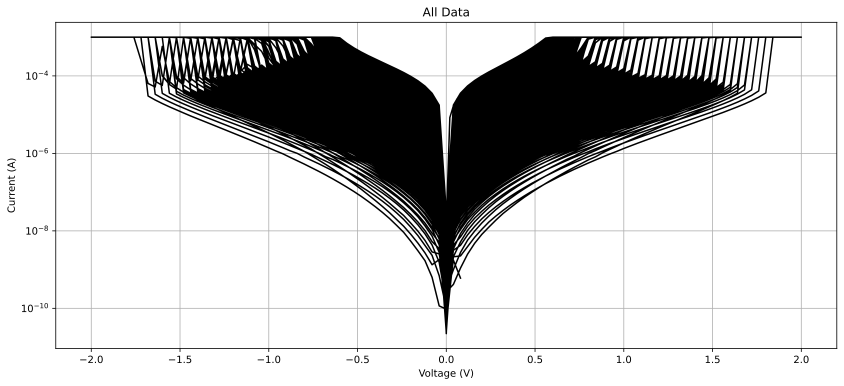

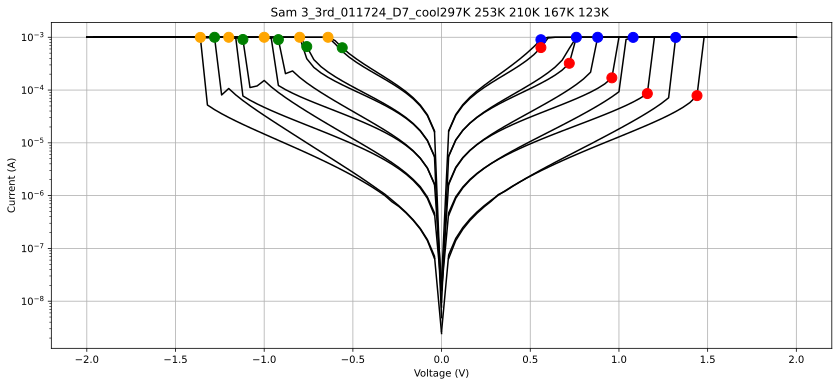

<Figure size 4200x1800 with 0 Axes>

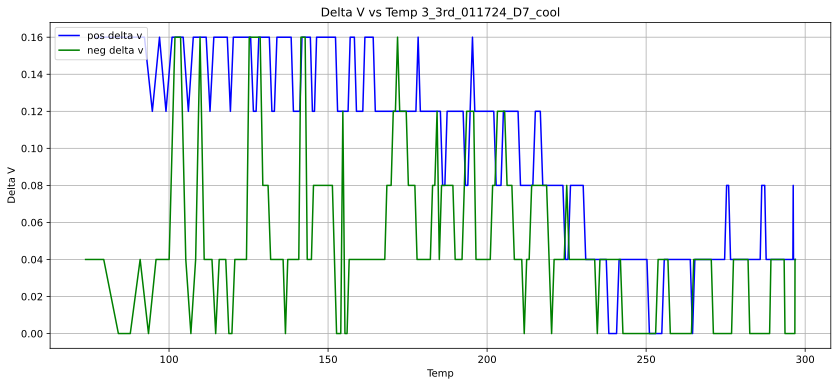

<Figure size 4200x1800 with 0 Axes>

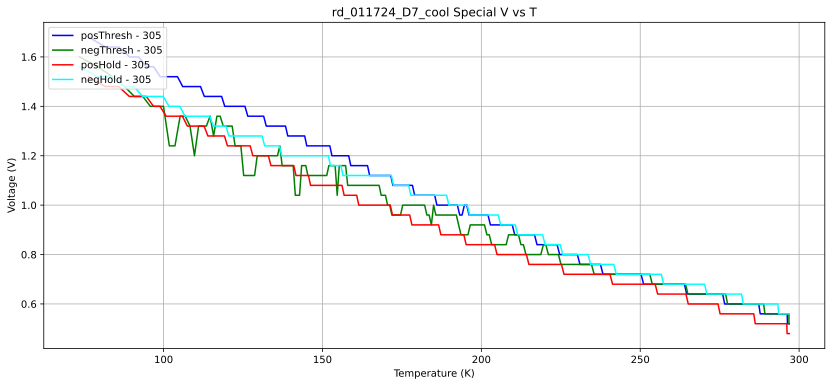

<Figure size 4200x1800 with 0 Axes>

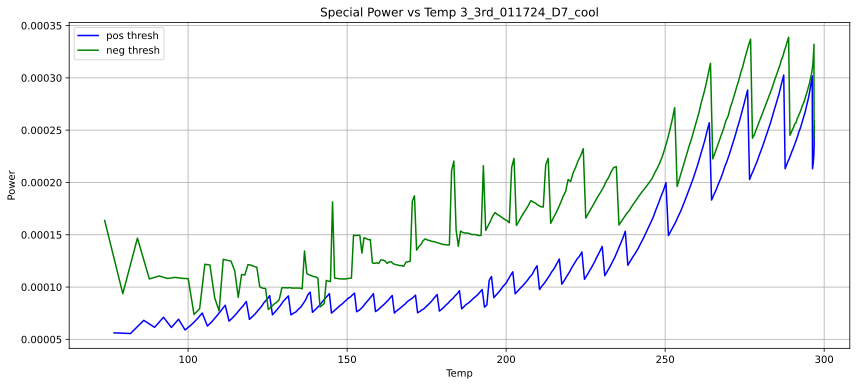

<Figure size 4200x1800 with 0 Axes>

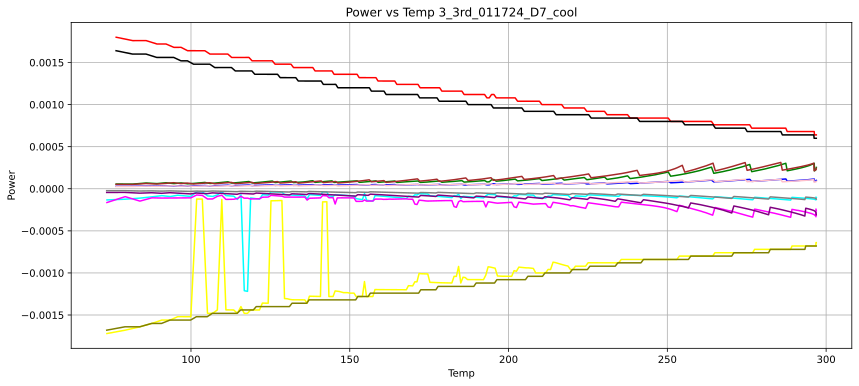

<Figure size 4200x1800 with 0 Axes>

/var/folders/y7/nfr2rwwn57jglbxxnjqph9dm0000gn/T/ipykernel_29108/1451291661.py:406: RuntimeWarning: divide by zero encountered in log10
  yAxis.append(np.log10(np.abs(tempYAxis[i][index])))


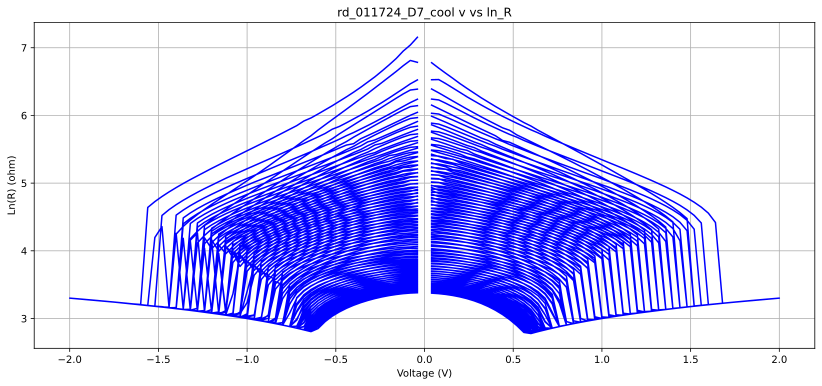

<Figure size 4200x1800 with 0 Axes>

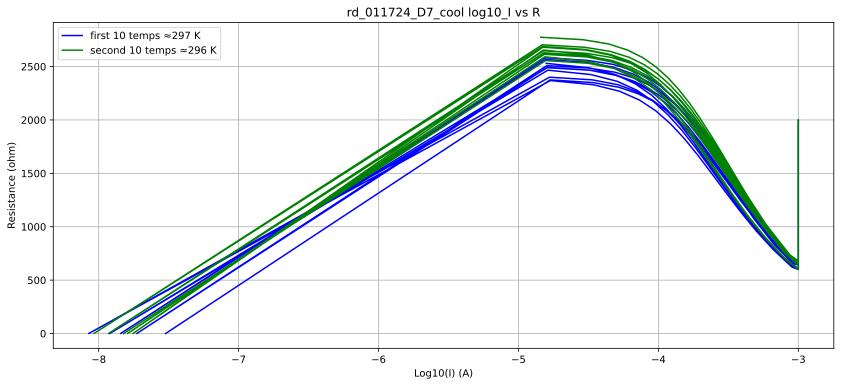

<Figure size 4200x1800 with 0 Axes>

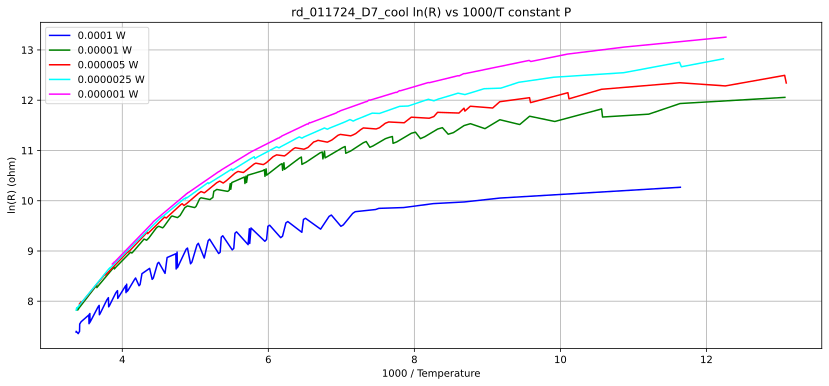

<Figure size 4200x1800 with 0 Axes>

IVs_NbO2_Ti0_Sam3_3rd_011724_D7_warm.txt
min temp: 65.5334055
max temp: 300.61394
step temp: 47.0161069
type_of_graph:  semilogy


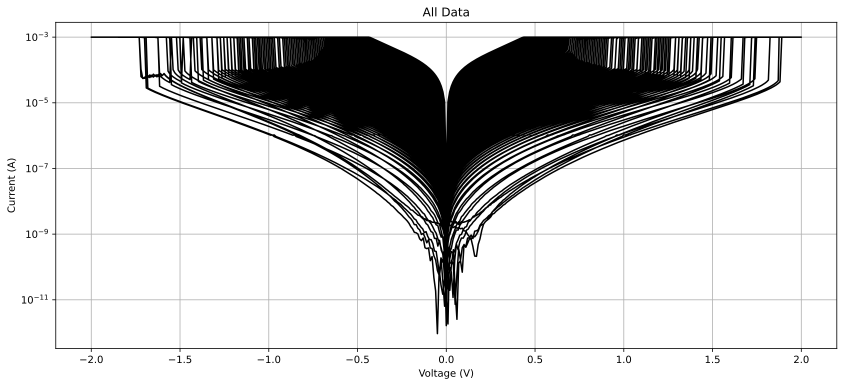

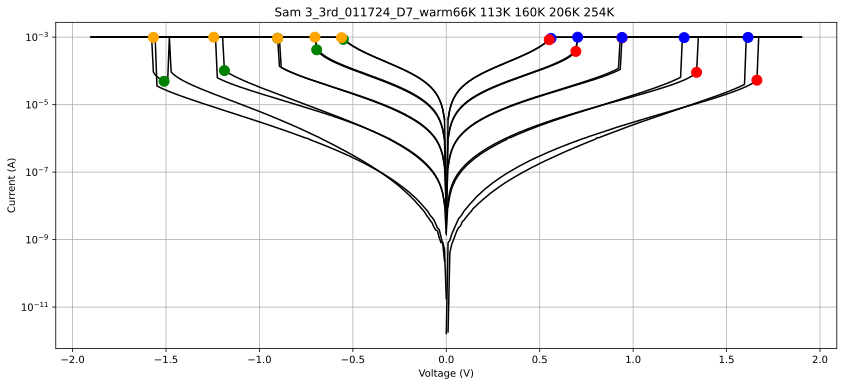

<Figure size 4200x1800 with 0 Axes>

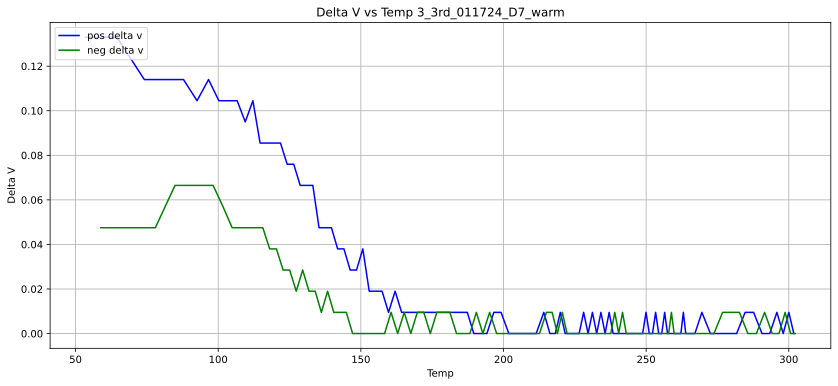

<Figure size 4200x1800 with 0 Axes>

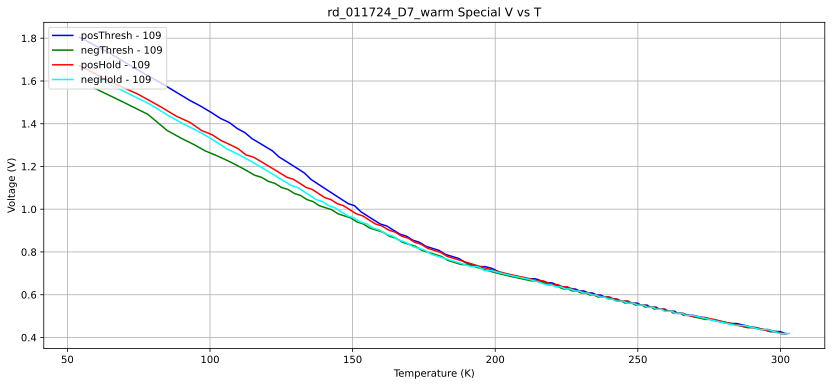

<Figure size 4200x1800 with 0 Axes>

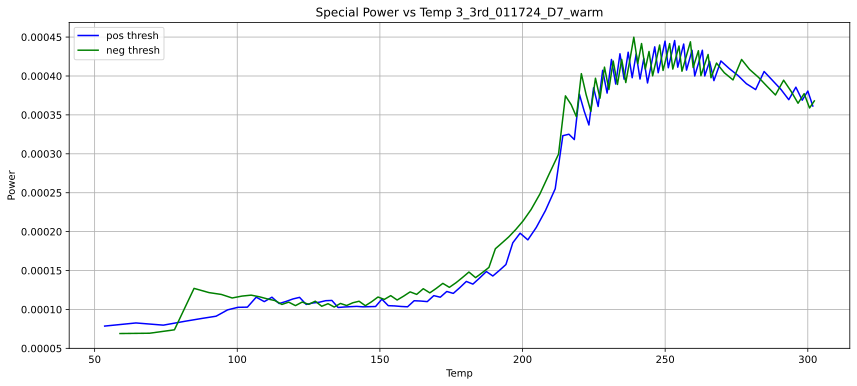

<Figure size 4200x1800 with 0 Axes>

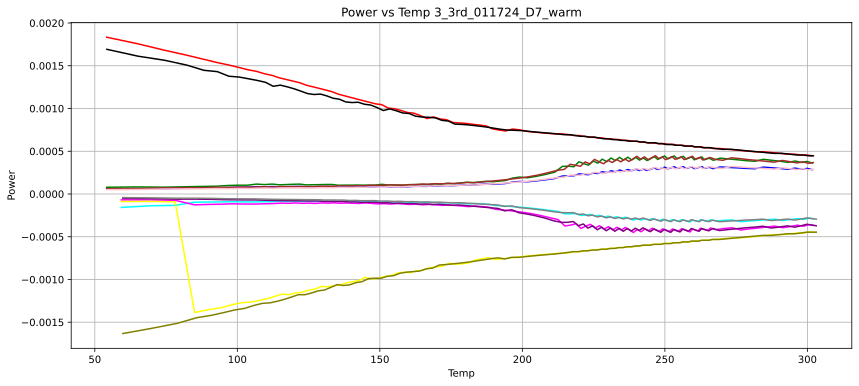

<Figure size 4200x1800 with 0 Axes>

/var/folders/y7/nfr2rwwn57jglbxxnjqph9dm0000gn/T/ipykernel_29108/1451291661.py:406: RuntimeWarning: divide by zero encountered in log10
  yAxis.append(np.log10(np.abs(tempYAxis[i][index])))


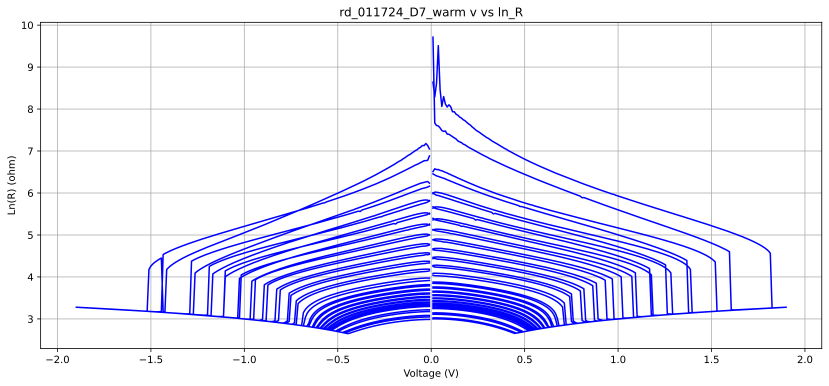

<Figure size 4200x1800 with 0 Axes>

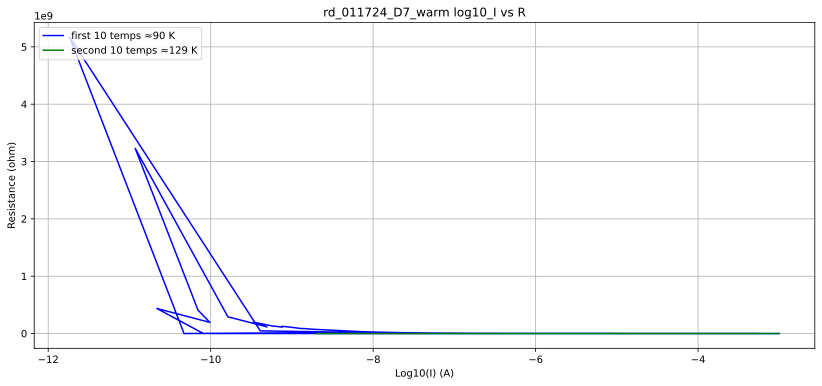

<Figure size 4200x1800 with 0 Axes>

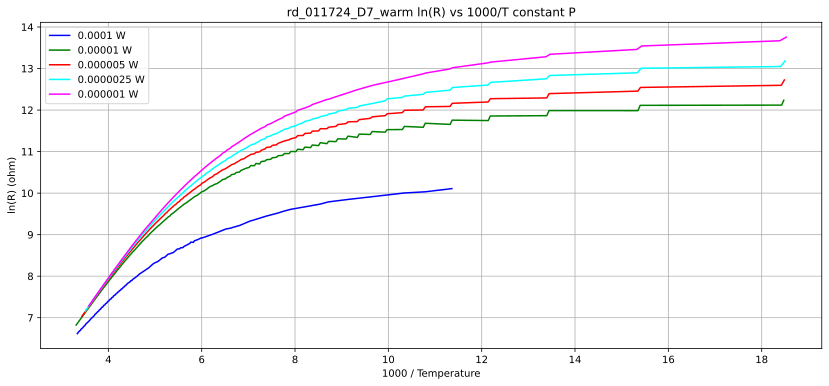

<Figure size 4200x1800 with 0 Axes>

In [1128]:
# theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/Nb02_v2/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");
# print("path: ", os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt")
# theFile = DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt")

# newest file: IVs_NbO2_Ti0_2nd_Sam2_053023_D13_cool

# theFiles = [
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_50ms_0msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_100ms_0msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_100ms_100msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_500msbreak.txt"),
#     DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_1000msbreak.txt")
# ]

theFiles = [
    
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam12_061523_D14_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam17_062823_D1_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_warm.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_cool_v2.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_warm.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam4_072723_D10_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam3_100223_D2_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam3_100323_D2_warm.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_KBSky1921ann_Sam22b_110623_D17.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_KBSky1921ann_Sam22b_110723_D1.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_KBSky1921unann_Sam23b_111523_D3.txt"),


    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_111523_D3_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_112723_D2_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_112923_D4_cool.txt"),


    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam12_061523_D14_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam17_062823_D1_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_warm.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_112723_D2_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_112923_D4_cool.txt"),


    DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011724_D7_cool.txt"),
    DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011724_D7_warm.txt"),

    # IVs_NbO2_Ti0_Sam3_3rd_011724_D7_cool
    # IVs_NbO2_Ti0_Sam3_3rd_011724_D7_warm



# #new data: dec 2023 - jan 2024
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D9_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D10_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D11_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D11_test.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D12_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_121823_D12_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D13_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D14_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D15_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D16_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D17_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D17_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D17_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D18_test.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D19_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D19_test.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D19_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D20_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D21_test.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122023_D22_test.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122223_D20_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122223_D20_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122223_D21_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_122223_D21_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011024_D4_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011124_D4_warm.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011124_D16_cool.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011124_D16_warm.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011224_D17_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011224_D17_warm.txt"),
#     # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011324_D18_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011424_D19_cool.txt"),
#     DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011424_D19_warm.txt"),







    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_cool_v2.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_warm.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam4_073023_D4_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_2nd_Sam4_072723_D10_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_100223_D2_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_100323_D2_warm.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_KBSky1921ann_Sam22b_110623_D17.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_KBSky1921ann_Sam22b_110723_D1.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_KBSky1921unann_Sam23b_111523_D3.txt"),


    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_111523_D3_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_112723_D2_cool.txt"),
    # DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_Sam15_2nd_112923_D4_cool.txt"),


    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_111523_D3_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_112723_D2_cool.txt"),
    # DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam15_2nd_112923_D4_cool.txt"),

    

]






























# theFiles[0].graph_all_data()
# theFiles[0].graph_resistance_vs_temp()

# data_to_graph = theFiles[0].return_resistances_at_current(1e-4)

# the_graph = Graph(
#             "R at I: " + theFiles[0].file_name[13:-4],   # title
#             "Type of Data",                             # xlabel
#             "Voltage (V)",                          # ylabel
#             [],                                     # hlines
#             "plot",                                  # type of graph
#             [data_to_graph],                          # data to graph
#             [],                                     # points
#         )

for file in theFiles:
    file.graph_all_data()
    # file.graph_log_r_vs_1_over_temp_by_voltage()
    # file.graph_log_r_vs_1_over_temp()
    # file.graph_combined_log_r_vs_1_over_temp()

    # file.graph_combined_log_r_vs_1_over_temp_vs_p("current")
    # file.graph_combined_log_r_vs_1_over_temp_vs_p("voltage")
    file.overlay_IV_curves(5)
    file.graph_delta_v_vs_temp()
    file.graph_voltage_vs_temp_type()
    file.graph_special_power_vs_temp()
    file.graph_power_vs_temp()

    file.graph_log_r_vs_voltage()
    file.graph_r_vs_log_i()
    file.graph_R_vs_T_constant_P()

    # file.graph_IV_curves(4)
    # file.graph_IV_curve(0)
    # file.graph_IV_curve(1)
    # file.graph_IV_curve(2)
    # file.graph_IV_curve(3)
    # file.graph_IV_curve(4)
    # file.graph_IV_curve(5)
    # file.graph_IV_curve(6)
    # file.graph_IV_curve(7)
    # file.graph_IV_curve(185)
    # file.graph_IV_curve(380)
    
    # file.graph_voltage_vs_temp()
    # data_to_graph.append(file.return_voltage_vs_temp())
    # file.graph_voltage_vs_temp()






# def animate(i):

#     x = []
#     y = []
    
#     normal_i = i
#     i = i * (int)(len(theFile.IV_curves) / 100)

#     print("progress ", i, "/", len(theFile.IV_curves))

#     points_to_graph = []

#     # print("range: ", len(theFile.IV_curves[0]['V'] - 1))
#     for index in range(len(theFile.IV_curves[i]['V']) - 1):

#         four_curves_x = [
#             theFile.IV_curves[i + 0]['V'].tolist(),
#             theFile.IV_curves[i + 1]['V'].tolist(),
#             theFile.IV_curves[i + 2]['V'].tolist(),
#             theFile.IV_curves[i + 3]['V'].tolist(),
#             ]
        
#         four_curves_y = [
#             theFile.IV_curves[i + 0]['I'].tolist(),
#             theFile.IV_curves[i + 1]['I'].tolist(),
#             theFile.IV_curves[i + 2]['I'].tolist(),
#             theFile.IV_curves[i + 3]['I'].tolist(),
#             ]
        
#         fine_tune = 0
#         index_to_graph = [
#             theFile.IV_curves[i + 0]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 1]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 2]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 3]['max_ddI'] + fine_tune,
#             ]
        
#         points_to_graph = [
#             [theFile.IV_curves[i + 0]['V'][index_to_graph[0]], theFile.IV_curves[i + 0]['I'][index_to_graph[0]]],
#             [theFile.IV_curves[i + 1]['V'][index_to_graph[1]], theFile.IV_curves[i + 1]['I'][index_to_graph[1]]],
#             [theFile.IV_curves[i + 2]['V'][index_to_graph[2]], theFile.IV_curves[i + 2]['I'][index_to_graph[2]]],
#             [theFile.IV_curves[i + 3]['V'][index_to_graph[3]], theFile.IV_curves[i + 3]['I'][index_to_graph[3]]],
#         ]
        
#         # voltage = self.IV_curves[index + i]['V']
#         # current = self.IV_curves[index + i]['I']
#         # data_to_graph.append([voltage, current])

#         # fine_tune = 0
#         # type_of_data = self.IV_curves[index + i]['type_of_data']
#         # if type_of_data == "posThresh":
#         #     fine_tune = 1
#         # if type_of_data == "negThresh":
#         #     fine_tune = 1
#         # if type_of_data == "posHold":
#         #     fine_tune = -2
#         # if type_of_data == "negHold":
#         #     fine_tune = -2
        
#         # index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
#         # points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])
        
        
        
        
        
#         # print("V: ", four_curves_x)
#         # print("sum: ", sum(four_curves_x, []))
        
#         x.append(sum(four_curves_x, []))
#         y.append(sum(four_curves_y, []))

#         # print("type:", sum(x, []))



#         # 'time': self.time[start:stop],
#         # 'I': self.I[start:stop],
#         # 'dI': dI,
#         # 'ddI': ddI,
#         # 'V': self.V[start:stop],
#         # 'temps': self.temps[start:stop],
#         # 'temp': run_temp,
#         # 'temp_std': run_temp_std,
#         # 'type_of_data': sort_into_side(self.V[start:stop], self.I[start:stop]),
#         # 'max_ddI': np.argmax(ddI),


#         # print("points_to_graph: ", points_to_graph)
#         # for point in points_to_graph:
#         #     plt.plot(point[0], point[1], marker="o", markersize=10, markeredgecolor='red', markerfacecolor='red')
    
#     title_time = "  Time =" + str(round(theFile.IV_curves[i]['time'][0])) + " s"
#     title_temp = "  Temp =" + str(round(theFile.IV_curves[i]['temp'])) + " K" + " Std: " + str(round(theFile.IV_curves[i]['temp_std'], 3))
#     title = "IV curve # " + str(i) + title_time + title_temp + " " + theFile.file_name
#     ax.set_title(title)
#     line.set_xdata(sum(x, []))  # update the data.
#     line.set_ydata(sum(y, []))  # update the data.
#     return line,


# # ani = animation.FuncAnimation(
# #     fig, animate, interval=50, blit=True, save_count=100)
# #                 # time between frames (ms)    number of frames
# # ani.save(theFile.file_name[:-4] + ".gif")

# # plt.show()




asdf

y = 1.88x + 0.56


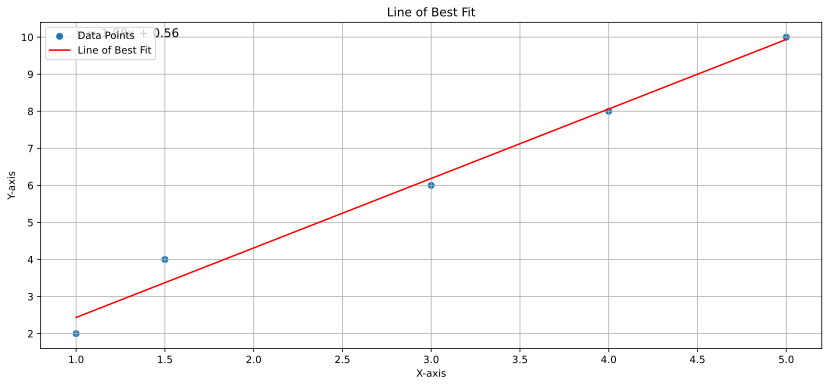

In [1129]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Sample data
x = np.array([1, 1.5, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])




# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create the line of best fit
line_of_best_fit = slope * x + intercept

# Create a scatter plot of the data and add the line of best fit
plt.scatter(x, y, label="Data Points")
plt.plot(x, line_of_best_fit, label="Line of Best Fit", color='red')

# Add labels, title, legend, and grid lines
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Line of Best Fit")
plt.legend()
plt.grid(True)

# Display the regression equation
regression_equation = f"y = {slope:.2f}x + {intercept:.2f}"
print(regression_equation)
plt.annotate(regression_equation, (x[0], y[-1]), fontsize=12)

# Show the plot
plt.show()
